## Mixture Kernel With non-stationary local weight

The Gaussian process in consideration is a mixture of independent processes. In specific, there is one global process $\mathcal{GP}_{g}$ and a collection of local processes $\{\mathcal{GP}_{l_i}\}$. A local non-stationary weight is added to each of the processes, to balance between exploring with global process and exploiting with local processes. The weight is modeled as Gaussian functions, to give the expression below:
\begin{gather*}
    f(\mathbf{x}) = e^{-\frac{\lVert \mathbf{x}-\pmb{\psi_g}\rVert_2^2}{2*\sigma_g^2}} f_{g}(\mathbf{x}) + \sum_i e^{-\frac{\lVert \mathbf{x}-\pmb{\psi_l}\rVert_2^2}{2*\sigma_{l_i}^2}} f_{l_i}(\mathbf{x}),\\
    f_{g} \sim \mathcal{GP}_{g},\quad f_{l_i} \sim \mathcal{GP}_{l_i},
\end{gather*}

$\pmb{\psi}$ denotes the position of the center of the influence region of a process.

Additivity of Gaussian processes results in the sum being Gaussian processes. If we further assume no correlation between the $\mathcal{GP}$ s, then we may describe $\mathcal{GP}_{tot}:\ f(\mathbf{x})\sim\mathcal{GP}_{tot}$ uniquely with mean function and covariance kernel as:

\begin{align*}
    k(\mathbf x_1, \mathbf x_2) = &\exp\left(\frac{\lVert \mathbf{x_1}-\pmb{\psi_g}\rVert_2^2 + \lVert \mathbf{x_2}-\pmb{\psi_g}\rVert_2^2}{2\sigma_g^2}\right)k_g(\mathbf x_1, \mathbf x_2)\\
    &+\sum_i \exp\left(\frac{\lVert \mathbf{x_1}-\pmb{\psi_g}\rVert_2^2 + \lVert \mathbf{x_2}-\pmb{\psi_g}\rVert_2^2}{2\sigma_{l_i}^2}\right)k_{l_i}(\mathbf x_1, \mathbf x_2),\\
        m(\mathbf x) = & m_g(\mathbf{x}) + \sum_i m_{l_i}(\mathbf{x}) 
\end{align*}


Our assumptions are: 1). Local Kernels are at a same place, and the areas of influence are isotropic. 2). input of $\mathbf x$ is vaguely standardized to $[-1,1]_d$, which can be used for setting the priors of sub-kernel hyperparameters and position/weights hyperparameters. 3). Global kernel has near uniform weight, which can be simulated by placing at $\pmb{\psi_g} = [0.5]_d$ and $\sigma_g$ being large, e.g. taken to be 10. 4). Global weight $\sigma_g$ isn't a hyperparameter, while local weights $\sigma_{l_i}$ s are hyperparameters. If necessary, we can use a unified $\sigma_{l}$. 5). To emphasize the local/global weights, $\sigma_l \ll \sigma_g$ might also be necessary. The practical hyperparameter might be $\sigma_l/\sigma_g$, constrained to $(0,1)$, or its logarithm constrained to $(-\infty,0)$, instead of $\sigma_l$.


In [4]:
# Imports

import torch, gpytorch
from GaussianWeightSpartan import Gaussian_Weight_Spartan_Kernel
from Spartan import SpartanKernel

Here we show a rough example that the code works, before testing priors:

In [5]:
# Plotting function
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def plot_gptorch(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval for models defined in GPyTorch """
    X_ = X.numpy()
    m_ = m.numpy()
    C_ = C.numpy()
    # Plot 95% confidence interval
    plt.fill_between(X_[:],
                     m_[:] - 1.96*np.sqrt(C_),
                     m_[:] + 1.96*np.sqrt(C_),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X_, m_, "-")
    plt.legend(labels=["GP fit"])

    plt.xlabel("x"), plt.ylabel("f")

    # Plot training points if included
    if training_points is not None:
        X__, Y__ = (training_points[0].numpy().reshape(-1),training_points[1].numpy().reshape(-1))
        plt.plot(X__, Y__, "kx", mew=2)
        plt.legend(labels=["GP fit", "GP center", "sample points"])


In [6]:
# model definition
from gpytorch.kernels import RBFKernel
from gpytorch.priors import LogNormalPrior, NormalPrior
class Loc_1D_RBF(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(Loc_1D_RBF, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        covar_module = Gaussian_Weight_Spartan_Kernel(RBFKernel(1), 
                                          [RBFKernel(1, lengthscale_prior=
                                          NormalPrior(0.1,0.05)) for i in range(2)],
                                          ard_num_dims=1,
                                          local_position_prior=NormalPrior(0.5,0.2),
                                          local_weight_var_prior=NormalPrior(0.1,0.05))
        covar_module.global_kernel.register_prior("lengthscale_prior", 
                                    LogNormalPrior(loc = torch.zeros(1), scale=1*torch.ones(1)),
                                    covar_module.global_kernel._lengthscale_param,
                                    covar_module.global_kernel._lengthscale_closure)
        self.covar_module = gpytorch.kernels.ScaleKernel(covar_module)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

In [7]:
# Defining training data
from math import pi
steps = 20
Xt = torch.linspace(0,1,20, dtype=torch.float64)
yt_func = lambda x: torch.sin(torch.pow((x),4.)*4*pi)
Yt= yt_func(Xt) + torch.randn_like(Xt)*0.05




Iter 1 - Loss: 0.226 noise: 0.111 variance: 0.408 position: 0.685 locallengthscale: 0.092 globallengthscale: 0.613 localweightvar: 0.109
Iter 2 - Loss: -0.144 noise: 0.005 variance: 0.165 position: 0.835 locallengthscale: 0.022 globallengthscale: 0.156 localweightvar: 0.132
Iter 3 - Loss: -0.356 noise: 0.002 variance: 0.631 position: 0.851 locallengthscale: 0.046 globallengthscale: 0.230 localweightvar: 0.111
Iter 4 - Loss: -0.357 noise: 0.002 variance: 0.598 position: 0.849 locallengthscale: 0.046 globallengthscale: 0.225 localweightvar: 0.111
Iter 5 - Loss: -0.357 noise: 0.002 variance: 0.576 position: 0.849 locallengthscale: 0.046 globallengthscale: 0.223 localweightvar: 0.112
Iter 6 - Loss: -0.357 noise: 0.002 variance: 0.574 position: 0.849 locallengthscale: 0.046 globallengthscale: 0.223 localweightvar: 0.112
Iter 7 - Loss: -0.357 noise: 0.002 variance: 0.574 position: 0.849 locallengthscale: 0.046 globallengthscale: 0.223 localweightvar: 0.112
Iter 8 - Loss: -0.357 noise: 0.002 

Text(0.5, 1.0, 'GPyTorch regression model fit with likelihood, Spartan RBF')

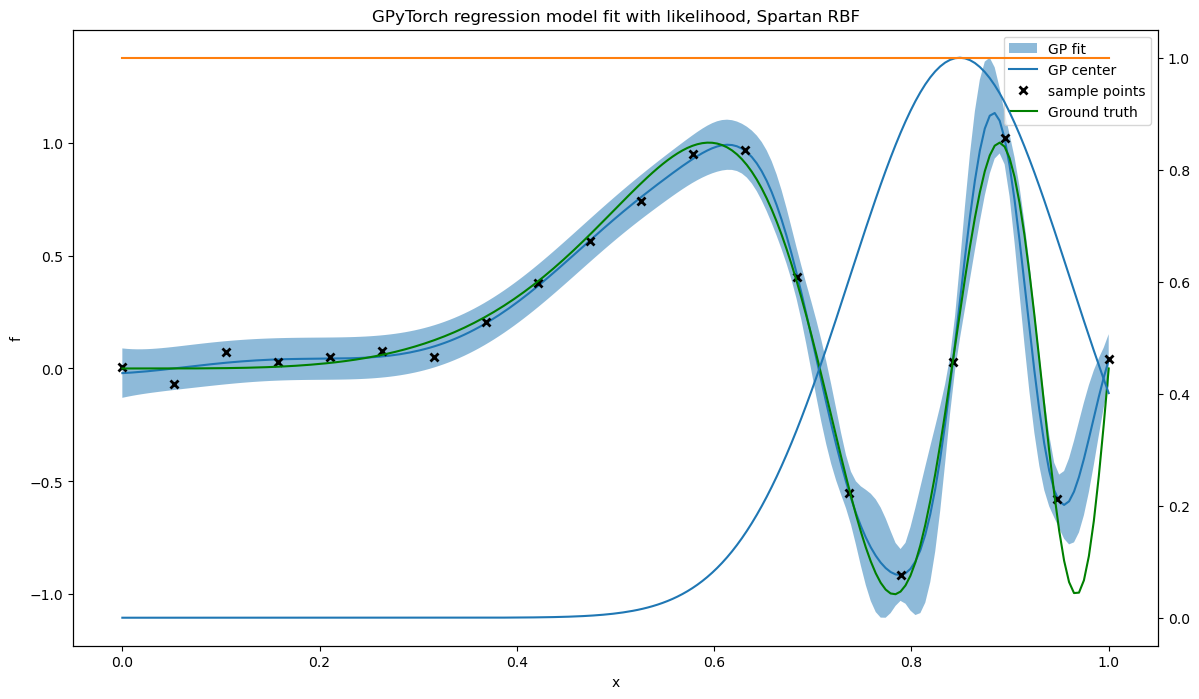

In [8]:
from gpytorch.constraints import Interval
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = Interval(lower_bound=1e-6, upper_bound = 1))
model0 = Loc_1D_RBF(train_inputs=Xt, train_targets=Yt,likelihood=likelihood)

import timeit
Xt = Xt.cpu()
Yt = Yt.cpu()

start_time = timeit.default_timer()
# Spartan
#likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = Interval(lower_bound=1e-6, upper_bound = 1))
#likelihood = gpytorch.likelihoods.GaussianLikelihood()
model0.covar_module.base_kernel._set_local_position(0.5)
#for lk in model0.covar_module.base_kernel.local_kernels:
#    lk.raw_lengthscale_constraint = Interval(lower_bound=0.05, 
#                                             upper_bound=0.2)
model0.train()
likelihood.train()
training_iter = 50
optimizer = torch.optim.LBFGS(model0.parameters(), lr=0.11, line_search_fn="strong_wolfe")
# "Loss" for GPs - the marginal log likelihood
#model0.likelihood.noise_covar.raw_noise.requires_grad_(False)

losstrack = 100
lossdif = 100
numcount = 0
steplength = torch.tensor([1])
for i in range(training_iter):
    def closure():
        # Zero gradients from previous iteration
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model0)
        optimizer.zero_grad()
        # Output from model
        output = model0(Xt)
        # Calc loss and backprop gradients
        loss = -mll(output, Yt)
        loss.backward()
        return loss
        
    optimizer.step(closure)
    loss = closure()
    print('Iter %d - Loss: %.3f noise: %.3f variance: %.3f position: %.3f locallengthscale: %.3f globallengthscale: %.3f localweightvar: %.3f'  % (
            i + 1, loss.item(),
            #model.covar_module.base_kernel.lengthscale.item(),
            model0.likelihood.noise.item(),
            model0.covar_module.outputscale.item(),
            model0.covar_module.base_kernel.local_position.item(),
            model0.covar_module.base_kernel.local_kernels[0].lengthscale.item(),
            model0.covar_module.base_kernel.global_kernel.lengthscale.item(),
            model0.covar_module.base_kernel.local_weight_var[0].item()
        ))
model0.eval()
likelihood.eval()

end_time = timeit.default_timer()

elapsed_time = end_time - start_time
print(f'Time elapsed: {elapsed_time} seconds')

Xtnew = torch.linspace(0,1,200)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model0(Xtnew)) # With noise liklihood
plt.figure(figsize=(14, 8))
# Plot the GP fit mean and covariance
plot_gptorch(Xtnew, observed_pred.mean, observed_pred.variance.detach(), 
             training_points=(Xt, Yt))
plt.plot(Xtnew, yt_func(Xtnew), 'g')
plt.legend(labels=["GP fit", "GP center", "sample points", "Ground truth"])
weights = plt.twinx()
#model0.covar_module.base_kernel.local_weight_var = model0.covar_module.base_kernel.local_weight_var/2
weights.plot(Xtnew.numpy(), model0.covar_module.base_kernel.omega_l(Xtnew.unsqueeze(-1),
firstkernel=True, log_prob = False).detach().numpy())
weights.plot(Xtnew.numpy(), torch.ones_like(Xtnew).numpy())
plt.title("GPyTorch regression model fit with likelihood, Spartan RBF")

In [9]:
with torch.no_grad():
    for name, param in model0.named_parameters():
        print(name, param)

likelihood.noise_covar.raw_noise Parameter containing:
tensor([-6.3672], requires_grad=True)
mean_module.raw_constant Parameter containing:
tensor(0.3174, requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(-0.2545, requires_grad=True)
covar_module.base_kernel.raw_local_position Parameter containing:
tensor(0.8489, requires_grad=True)
covar_module.base_kernel.raw_local_weight_var Parameter containing:
tensor([-2.0729, -2.0729], requires_grad=True)
covar_module.base_kernel.global_kernel.raw_lengthscale Parameter containing:
tensor([[-1.3863]], requires_grad=True)
covar_module.base_kernel.local_kernels.0.raw_lengthscale Parameter containing:
tensor([[-3.0602]], requires_grad=True)
covar_module.base_kernel.local_kernels.1.raw_lengthscale Parameter containing:
tensor([[-3.0602]], requires_grad=True)


We test the model without any priors or constraints, initiating at different locations, and observe the results:

When saying "without any priors or constraints", for consistency, non-negative constraints are imposed when necessary. In order to handle noiseless data we may also manually set noise constraints to be low enough.

In [10]:
from gpytorch.constraints import Positive

class Loc_1D_RBF_Free(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(Loc_1D_RBF_Free, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
        covar_module = Gaussian_Weight_Spartan_Kernel(RBFKernel(1), 
                                          [RBFKernel(1) for i in range(1)],
                                          ard_num_dims=1,
                                          local_weight_var_constraint=Positive())
        #covar_module.global_kernel.register_prior("lengthscale_prior", 
        #                            LogNormalPrior(loc = torch.zeros(1), scale=1*torch.ones(1)),
        #                            covar_module.global_kernel._lengthscale_param,
        #                            covar_module.global_kernel._lengthscale_closure)
        self.covar_module = gpytorch.kernels.ScaleKernel(covar_module)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

Iter 20 - Loss: -0.372 noise: 0.002 variance: 1.928 position: 0.877 locallengthscale: 0.116 globallengthscale: 1.092 localweightvar: 0.025
Iter 20 - Loss: -0.372 noise: 0.002 variance: 1.930 position: 0.877 locallengthscale: 0.117 globallengthscale: 1.093 localweightvar: 0.025
Iter 20 - Loss: -0.372 noise: 0.002 variance: 1.928 position: 0.877 locallengthscale: 0.096 globallengthscale: 1.092 localweightvar: 0.203
Iter 20 - Loss: -0.389 noise: 0.002 variance: 1.446 position: 0.879 locallengthscale: 0.085 globallengthscale: 0.261 localweightvar: 0.135
Iter 20 - Loss: -0.372 noise: 0.002 variance: 1.928 position: 0.877 locallengthscale: 0.096 globallengthscale: 1.092 localweightvar: 0.203


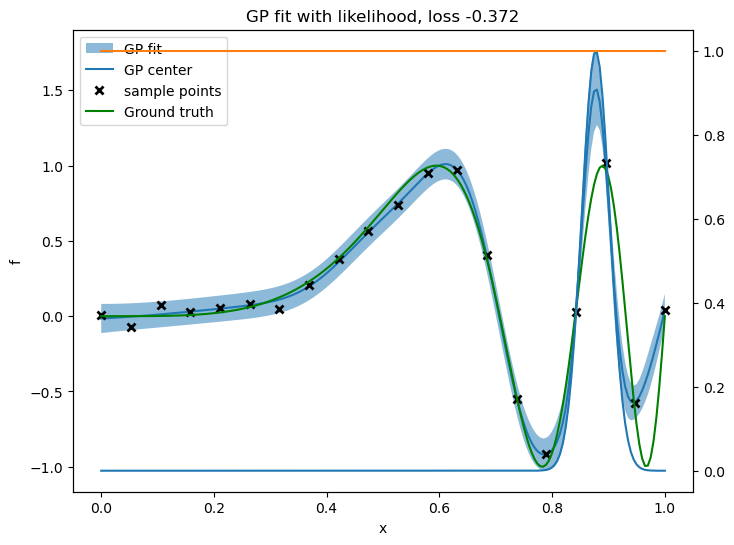

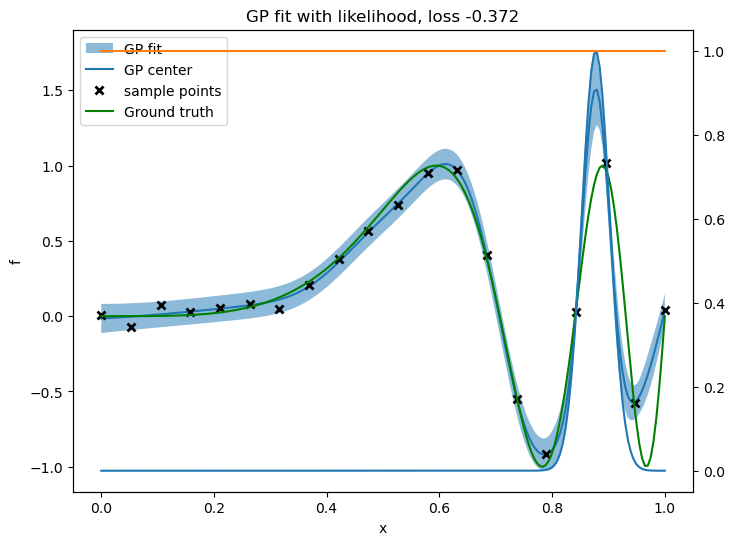

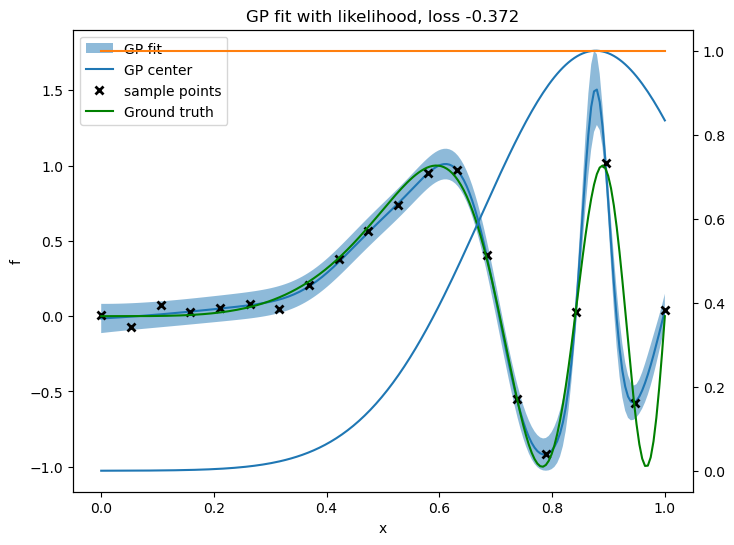

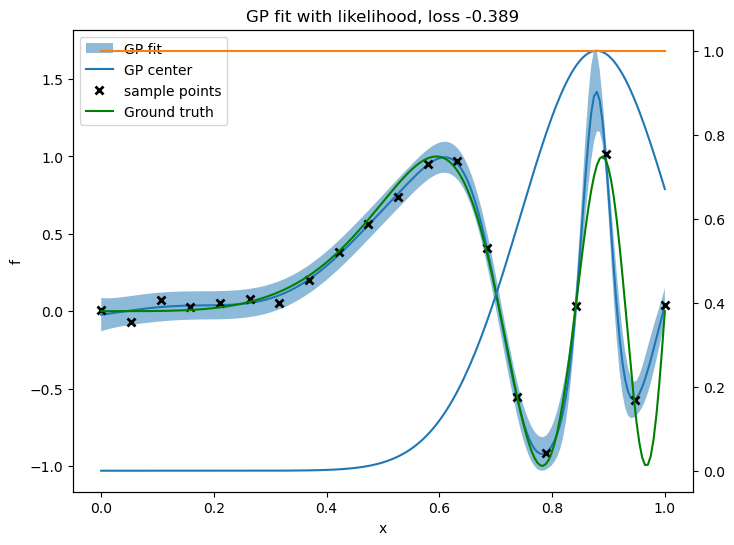

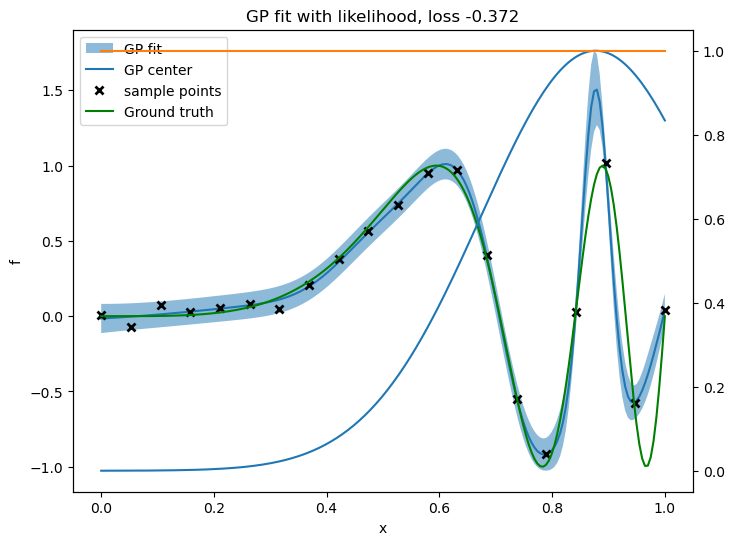

In [ ]:


for iter in range(100): 
    #start_time = timeit.default_timer()
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=Interval(1e-8,1.))
    model0 = Loc_1D_RBF(train_inputs=Xt, train_targets=Yt,likelihood=likelihood)
    model0.covar_module.base_kernel._set_local_position(0.5)
    model0.train()
    likelihood.train()
    for name, params in model0.named_hyperparameters():
        params.data.copy_(torch.randn_like(params.data)*2-0.5)
    #print('noise: %.3f variance: %.3f position: %.3f locallengthscale: %.3f globallengthscale: %.3f localweightvar: %.3f'  % (
    #        
    #        #model.covar_module.base_kernel.lengthscale.item(),
    #        model0.likelihood.noise.item(),
    #        model0.covar_module.outputscale.item(),
    #        model0.covar_module.base_kernel.local_position.item(),
    #        model0.covar_module.base_kernel.local_kernels[0].lengthscale.item(),
    #       model0.covar_module.base_kernel.global_kernel.lengthscale.item(),
    #        model0.covar_module.base_kernel.local_weight_var[0].item()
    #    ))
    training_iter = 20
    optimizer = torch.optim.LBFGS(model0.parameters(), lr=0.11, line_search_fn="strong_wolfe")
    #start_time = timeit.default_timer()
    # "Loss" for GPs - the marginal log likelihood
    #model0.likelihood.noise_covar.raw_noise.requires_grad_(False)

    losstrack = 100
    lossdif = 100
    numcount = 0
    steplength = torch.tensor([1])
    for i in range(training_iter):
        def closure():
            # Zero gradients from previous iteration
            mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model0)
            optimizer.zero_grad()
            # Output from model
            output = model0(Xt)
            # Calc loss and backprop gradients
            loss = -mll(output, Yt)
            loss.backward()
            return loss
            
        optimizer.step(closure)
        loss = closure()
    if loss.item() < -0.372:
        print('Iter %d - Loss: %.3f noise: %.3f variance: %.3f position: %.3f locallengthscale: %.3f globallengthscale: %.3f localweightvar: %.3f'  % (
                i + 1, loss.item(),
                #model.covar_module.base_kernel.lengthscale.item(),
                model0.likelihood.noise.item(),
                model0.covar_module.outputscale.item(),
                model0.covar_module.base_kernel.local_position.item(),
                model0.covar_module.base_kernel.local_kernels[0].lengthscale.item(),
                model0.covar_module.base_kernel.global_kernel.lengthscale.item(),
                model0.covar_module.base_kernel.local_weight_var[0].item()
            ))
        model0.eval()
        likelihood.eval()

        #end_time = timeit.default_timer()

        #elapsed_time = end_time - start_time
        #print(f'Time elapsed: {elapsed_time} seconds')

        Xtnew = torch.linspace(0,1,200)

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model0(Xtnew)) # With noise liklihood
        plt.figure(figsize=(8, 6))
        # Plot the GP fit mean and covariance
        plot_gptorch(Xtnew, observed_pred.mean, observed_pred.variance.detach(), 
                    training_points=(Xt, Yt))
        plt.plot(Xtnew, yt_func(Xtnew), 'g')
        plt.legend(labels=["GP fit", "GP center", "sample points", "Ground truth"])
        weights = plt.twinx()
        #model0.covar_module.base_kernel.local_weight_var = model0.covar_module.base_kernel.local_weight_var/2
        weights.plot(Xtnew.numpy(), model0.covar_module.base_kernel.omega_l(Xtnew.unsqueeze(-1),
        firstkernel=True, log_prob = False).detach().numpy())
        weights.plot(Xtnew.numpy(), torch.ones_like(Xtnew).numpy())
        plt.title("GP fit with likelihood, loss %.3f" % loss.item())


In [30]:
# Defining training data
from math import pi
steps = 20
Xt = torch.linspace(0,1,20, dtype=torch.float64)
yt_func = lambda x: torch.sin(torch.pow((x),4.)*4*pi)
Yt= yt_func(Xt)# + torch.randn_like(Xt)*0.05

Iter 20 - Loss: 0.267 noise: 0.177 variance: 0.089 position: 0.568 locallengthscale: 0.105 globallengthscale: 0.366 localweightvar: 0.103


Text(0.5, 1.0, 'GP fit with likelihood, loss 0.267')

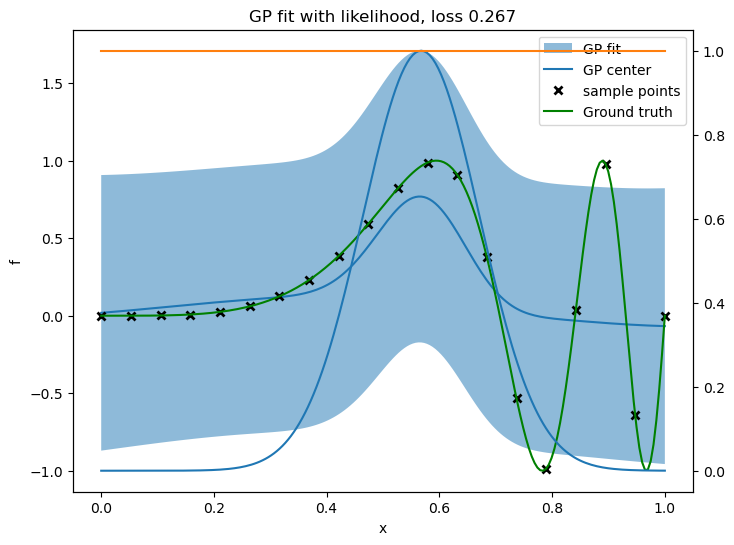

In [44]:
#start_time = timeit.default_timer()
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=Interval(1e-8,1.))
model0 = Loc_1D_RBF(train_inputs=Xt, train_targets=Yt,likelihood=likelihood)
model0.covar_module.base_kernel._set_local_position(0.5)
model0.train()
likelihood.train()
for name, params in model0.named_hyperparameters():
    params.data.copy_(torch.randn_like(params.data)*2-0.5)
#print('noise: %.3f variance: %.3f position: %.3f locallengthscale: %.3f globallengthscale: %.3f localweightvar: %.3f'  % (
#        
#        #model.covar_module.base_kernel.lengthscale.item(),
#        model0.likelihood.noise.item(),
#        model0.covar_module.outputscale.item(),
#        model0.covar_module.base_kernel.local_position.item(),
#        model0.covar_module.base_kernel.local_kernels[0].lengthscale.item(),
#       model0.covar_module.base_kernel.global_kernel.lengthscale.item(),
#        model0.covar_module.base_kernel.local_weight_var[0].item()
#    ))
training_iter = 20
optimizer = torch.optim.LBFGS(model0.parameters(), lr=0.11, line_search_fn="strong_wolfe")
#start_time = timeit.default_timer()
# "Loss" for GPs - the marginal log likelihood
#model0.likelihood.noise_covar.raw_noise.requires_grad_(False)

losstrack = 100
lossdif = 100
numcount = 0
steplength = torch.tensor([1])
for i in range(training_iter):
    def closure():
        # Zero gradients from previous iteration
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model0)
        optimizer.zero_grad()
        # Output from model
        output = model0(Xt)
        # Calc loss and backprop gradients
        loss = -mll(output, Yt)
        loss.backward()
        return loss
        
    optimizer.step(closure)
    loss = closure()

print('Iter %d - Loss: %.3f noise: %.3f variance: %.3f position: %.3f locallengthscale: %.3f globallengthscale: %.3f localweightvar: %.3f'  % (
        i + 1, loss.item(),
        #model.covar_module.base_kernel.lengthscale.item(),
        model0.likelihood.noise.item(),
        model0.covar_module.outputscale.item(),
        model0.covar_module.base_kernel.local_position.item(),
        model0.covar_module.base_kernel.local_kernels[0].lengthscale.item(),
        model0.covar_module.base_kernel.global_kernel.lengthscale.item(),
        model0.covar_module.base_kernel.local_weight_var[0].item()
    ))
model0.eval()
likelihood.eval()

#end_time = timeit.default_timer()

#elapsed_time = end_time - start_time
#print(f'Time elapsed: {elapsed_time} seconds')

Xtnew = torch.linspace(0,1,200)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model0(Xtnew)) # With noise liklihood
plt.figure(figsize=(8, 6))
# Plot the GP fit mean and covariance
plot_gptorch(Xtnew, observed_pred.mean, observed_pred.variance.detach(), 
            training_points=(Xt, Yt))
plt.plot(Xtnew, yt_func(Xtnew), 'g')
plt.legend(labels=["GP fit", "GP center", "sample points", "Ground truth"])
weights = plt.twinx()
#model0.covar_module.base_kernel.local_weight_var = model0.covar_module.base_kernel.local_weight_var/2
weights.plot(Xtnew.numpy(), model0.covar_module.base_kernel.omega_l(Xtnew.unsqueeze(-1),
firstkernel=True, log_prob = False).detach().numpy())
weights.plot(Xtnew.numpy(), torch.ones_like(Xtnew).numpy())
plt.title("GP fit with likelihood, loss %.3f" % loss.item())

### 2D test

We test the kernel with 2D data examples.

First, we state that the samples are drawn from Rosenbrock function.

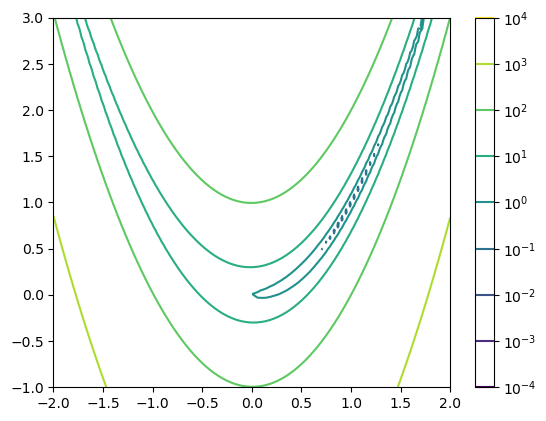

In [89]:
from matplotlib import ticker


Rosenbrock2D = lambda X: torch.sum(
            100.0 * ((X[..., 1:] - X[..., :-1] ** 2) ** 2) + (X[..., :-1] - 1) ** 2,
            dim=-1)
Xt2, Yt2 = torch.meshgrid(torch.linspace(-2,2,100), torch.linspace(-1,3,100))
plt.contour(Xt2.numpy(), Yt2.numpy(), Rosenbrock2D(torch.cat(tuple(torch.dstack([Xt2, Yt2])))).reshape(Xt2.shape).numpy(), 30,locator=ticker.LogLocator())
plt.colorbar()


These cells below are used to test that the scheme works in 2D, before testing with Rosenbrock:

In [135]:
from typing import Union


from linear_operator.operators import LinearOperator
from torch import Tensor
from torch.distributions import Distribution


class Spartan_2D_RBF_Adapt(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super().__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        covar_module = Gaussian_Weight_Spartan_Kernel(RBFKernel(2),
                                        [RBFKernel(2) for i in range(2)],
                                        ard_num_dims=2,
                                        )
        self.covar_module = gpytorch.kernels.ScaleKernel(covar_module)

    def forward(self, x) -> Tensor | Distribution | LinearOperator:
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


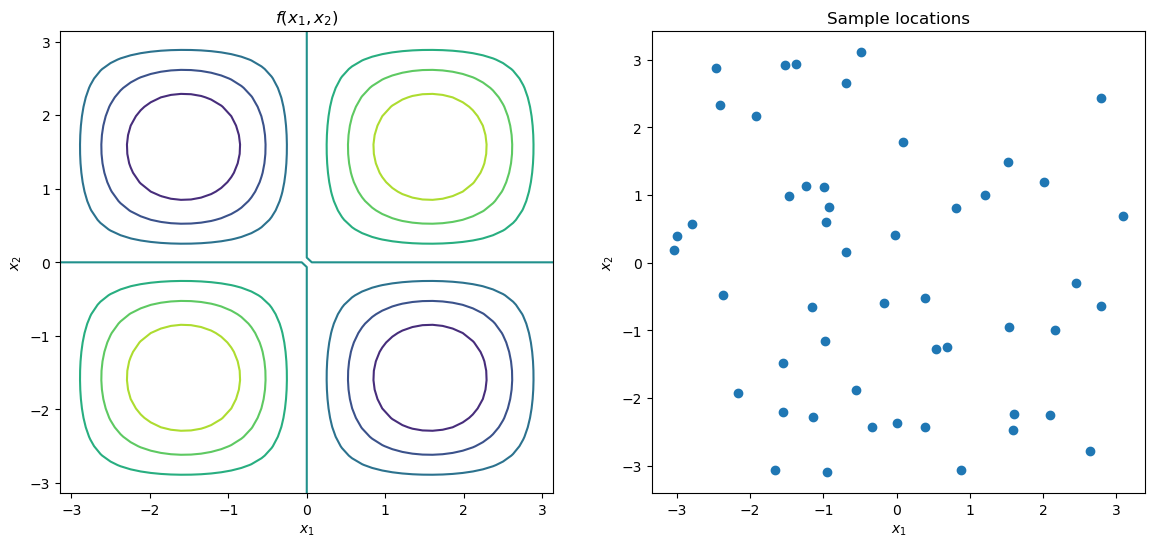

In [136]:
# Lambda function, f, the unknown function we are trying to predict
f = lambda xi,xj: np.sin(xi) * np.sin(xj)

# Our test grid
[Xi, Xj] = np.meshgrid(np.linspace(-np.pi, np.pi, 50), np.linspace(-np.pi, np.pi, 50))
Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T

# Number of samples [YOU CAN PLAY AROUND WITH THE NUMBER OF RANDOM SAMPLES TO SEE HOW THE FIT IS AFFECTED]
num_measurements = 50

# Random sample locations (2-D)
X2 = np.random.uniform(-np.pi, np.pi, (num_measurements, 2))

# Setup plot enviornment
plt.figure(figsize=(14, 6))

plt.subplot(121)
# Show true function
plt.contour(Xi, Xj, f(Xi,Xj))
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("$f(x_1,x_2)$")

plt.subplot(122)
# Show sample locations
plt.plot(X2[:,0],X2[:,1],'o')
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Sample locations");

In [137]:
Y2 = np.array([f(x1,x2) for (x1,x2) in zip(X2[:,0], X2[:,1])])[:,None] + 0.05 * np.random.randn(X2.shape[0], 1)

X2t = torch.from_numpy(X2)
Y2t = torch.from_numpy(Y2.T)
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.05
model2 = Spartan_2D_RBF_Adapt(X2t,Y2t,likelihood)
#model2(torch.tensor([[1.,2.]]))

In [130]:
model2.train()
likelihood.train()
# Use the Adam's optimizer
#model2.likelihood.noise_covar.raw_noise.requires_grad_(False)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
training_iter = 100
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model2)
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model2(X2t)
    # Calc loss and backprop gradients
    loss = -mll(output, Y2t)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   locallengthscale: %.3f   noise: %.3f variance: %.3f'  % (
        i + 1, training_iter, loss.item(),
        model2.covar_module.base_kernel.local_kernels[0].lengthscale[0,0],
        model2.likelihood.noise.item(),
        model2.covar_module.outputscale.item()
    ))
    optimizer.step()

Iter 1/100 - Loss: 0.480   locallengthscale: 0.693   noise: 0.050 variance: 0.693
Iter 2/100 - Loss: 0.404   locallengthscale: 0.744   noise: 0.045 variance: 0.644
Iter 3/100 - Loss: 0.325   locallengthscale: 0.795   noise: 0.041 variance: 0.598
Iter 4/100 - Loss: 0.247   locallengthscale: 0.845   noise: 0.037 variance: 0.555
Iter 5/100 - Loss: 0.171   locallengthscale: 0.893   noise: 0.034 variance: 0.513
Iter 6/100 - Loss: 0.099   locallengthscale: 0.941   noise: 0.031 variance: 0.475
Iter 7/100 - Loss: 0.028   locallengthscale: 0.988   noise: 0.028 variance: 0.439
Iter 8/100 - Loss: -0.039   locallengthscale: 1.034   noise: 0.025 variance: 0.406
Iter 9/100 - Loss: -0.101   locallengthscale: 1.078   noise: 0.023 variance: 0.375
Iter 10/100 - Loss: -0.156   locallengthscale: 1.120   noise: 0.020 variance: 0.347
Iter 11/100 - Loss: -0.204   locallengthscale: 1.159   noise: 0.018 variance: 0.321
Iter 12/100 - Loss: -0.242   locallengthscale: 1.195   noise: 0.017 variance: 0.299
Iter 13/

(Text(0.5, 1.0, 'Variance of GP fit'),
 <matplotlib.colorbar.Colorbar at 0x163e5a290>)

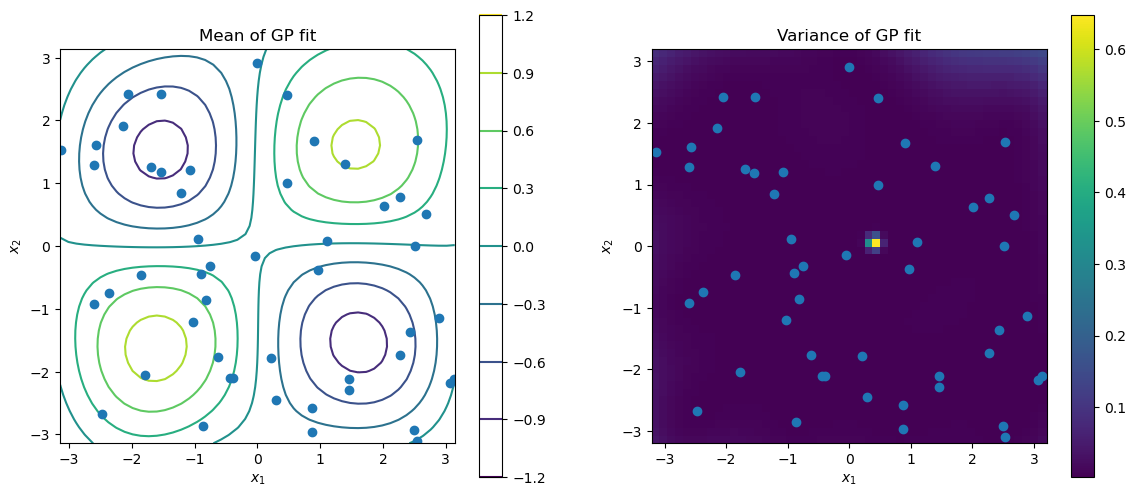

In [131]:
model2.eval()
likelihood.eval()
Xtnew2 = torch.from_numpy(Xnew2)
# Predict the mean and covariance of the GP fit at the test locations
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    model_pred = likelihood(model2(Xtnew2))
    cov2 = model_pred.variance
    mean2 = model_pred.mean
    
cov2 = cov2.numpy()
mean2 = mean2.numpy()
# Setup plot environment
plt.figure(figsize=(14, 6))

# Left plot shows mean of GP fit
plt.subplot(121)

# Plot mean surface
plt.contour(Xi, Xj, mean2.reshape(Xi.shape))
# Show sample locations
plt.plot(X2[:,0],X2[:,1],'o'), plt.axis("square")
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Mean of GP fit"), plt.colorbar()

# Right plot shows the variance of the GP
plt.subplot(122)
# Plot variance surface
plt.pcolor(Xi, Xj, cov2.reshape(Xi.shape))
# Show sample locations
plt.plot(X2[:,0],X2[:,1],'o'), plt.axis("square")
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Variance of GP fit"), plt.colorbar()

In [208]:
XYt2 = torch.rand(size = (400, 2), dtype=torch.float64)*4-torch.tensor([2,1])
Zt2 = torch.log(Rosenbrock2D(XYt2))
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.05
model2 = Spartan_2D_RBF_Adapt(XYt2,Zt2,likelihood)
#model2(torch.tensor([[1.,2.]]))

In [217]:
model2.train()
likelihood.train()
for name, params in model2.named_hyperparameters():
        params.data.copy_(torch.randn_like(params.data)*2-0.5)
# Use the Adam's optimizer
#model2.likelihood.noise_covar.raw_noise.requires_grad_(False)
optimizer = torch.optim.LBFGS(model2.parameters(), lr=0.1, line_search_fn="strong_wolfe")  # Includes GaussianLikelihood parameters
training_iter = 30
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model2)
for i in range(training_iter):
    def closure():
        # Zero gradients from previous iteration
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model2)
        optimizer.zero_grad()
        # Output from model
        output = model2(XYt2)
        # Calc loss and backprop gradients
        loss = -mll(output, Zt2)
        loss.backward()
        return loss
        
    optimizer.step(closure)
    loss = closure()
    print('Iter %d/%d - Loss: %.3f, globallengthscale: %.3f,  locallengthscale: %.3f   noise: %.3f variance: %.3f'  % (
        i + 1, training_iter, loss.item(),
        model2.covar_module.base_kernel.global_kernel.lengthscale[0,0],
        model2.covar_module.base_kernel.local_kernels[0].lengthscale[0,0],
        model2.likelihood.noise.item(),
        model2.covar_module.outputscale.item()
    ))

Iter 1/30 - Loss: 0.517, globallengthscale: 0.298,  locallengthscale: 0.293   noise: 0.007 variance: 4.081
Iter 2/30 - Loss: 0.379, globallengthscale: 0.213,  locallengthscale: 0.090   noise: 0.001 variance: 1.744
Iter 3/30 - Loss: 0.337, globallengthscale: 0.162,  locallengthscale: 0.114   noise: 0.000 variance: 2.165
Iter 4/30 - Loss: 0.301, globallengthscale: 0.153,  locallengthscale: 0.138   noise: 0.000 variance: 1.782
Iter 5/30 - Loss: 0.300, globallengthscale: 0.153,  locallengthscale: 0.138   noise: 0.000 variance: 1.782
Iter 6/30 - Loss: 0.300, globallengthscale: 0.153,  locallengthscale: 0.139   noise: 0.000 variance: 1.797
Iter 7/30 - Loss: 0.298, globallengthscale: 0.154,  locallengthscale: 0.142   noise: 0.000 variance: 1.910
Iter 8/30 - Loss: 0.298, globallengthscale: 0.154,  locallengthscale: 0.142   noise: 0.000 variance: 1.920
Iter 9/30 - Loss: 0.298, globallengthscale: 0.154,  locallengthscale: 0.142   noise: 0.000 variance: 1.920
Iter 10/30 - Loss: 0.298, globallengt

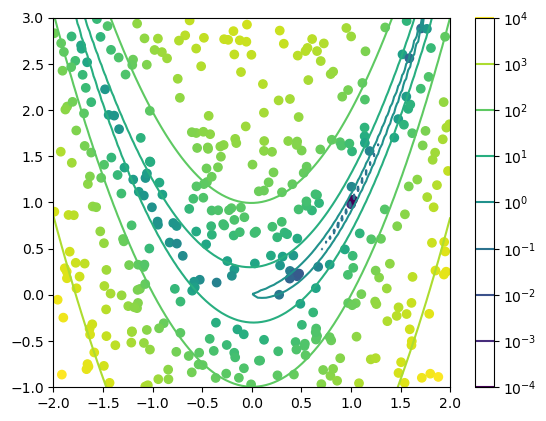

In [218]:
from matplotlib.colors import LogNorm
plt.scatter(XYt2[...,:-1].numpy(), XYt2[...,1:].numpy(), c=Zt2.numpy(), 
            #norm=LogNorm()
            )
plt.contour(Xt2.numpy(), Yt2.numpy(), Rosenbrock2D(torch.cat(tuple(torch.dstack([Xt2, Yt2])))).reshape(Xt2.shape).numpy(), 
            30,locator=ticker.LogLocator())
plt.colorbar()

(Text(0.5, 1.0, 'Variance of GP fit'),
 <matplotlib.colorbar.Colorbar at 0x2a774a210>)

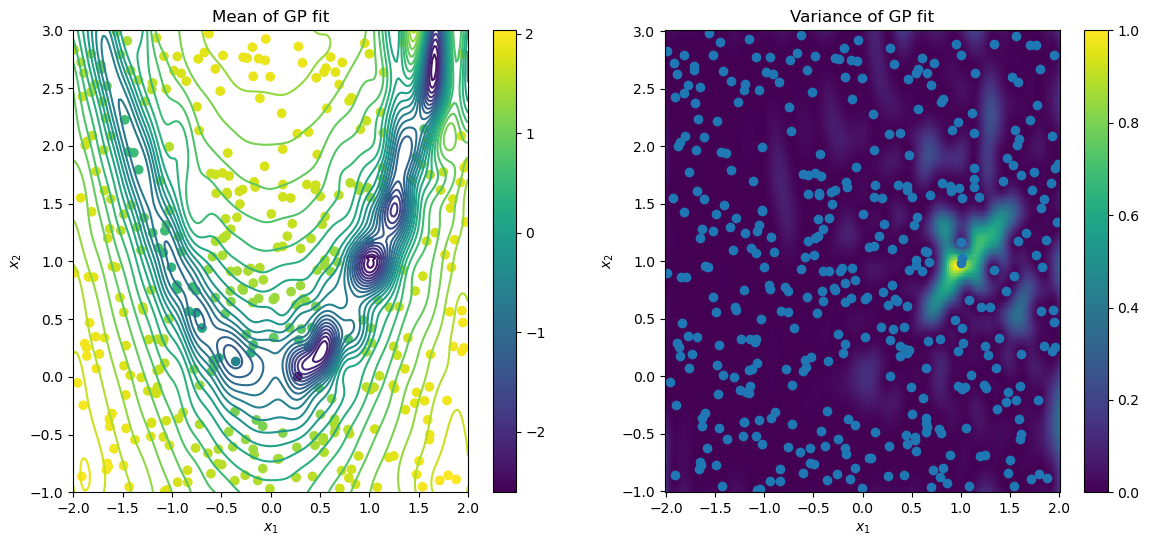

In [219]:
model2.eval()
likelihood.eval()
# Our test grid
[Xi, Xj] = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-1, 3, 200))
Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T
Xtnew2 = torch.from_numpy(Xnew2)
# Predict the mean and covariance of the GP fit at the test locations
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    model_pred = likelihood(model2(Xtnew2))
    cov2 = model_pred.variance
    mean2 = model_pred.mean
    
cov2 = cov2.numpy()
mean2 = mean2.numpy()
# Setup plot environment
plt.figure(figsize=(14, 6))

# Left plot shows mean of GP fit
plt.subplot(121)

# Plot mean surface
plt.contour(Xi, Xj, mean2.reshape(Xi.shape), 30)
# Show sample locations
plt.scatter(XYt2[...,:-1].numpy(), XYt2[...,1:].numpy(), c=Zt2.log().numpy(), 
            #norm=LogNorm()
            )
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Mean of GP fit"), plt.colorbar()

# Right plot shows the variance of the GP
plt.subplot(122)
# Plot variance surface
plt.pcolor(Xi, Xj, cov2.reshape(Xi.shape))
# Show sample locations
plt.scatter(XYt2[...,:-1].numpy(), XYt2[...,1:].numpy()
            #norm=LogNorm()
            )
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Variance of GP fit"), plt.colorbar()

Text(0.5, 1.0, 'Local Gaussian weight')

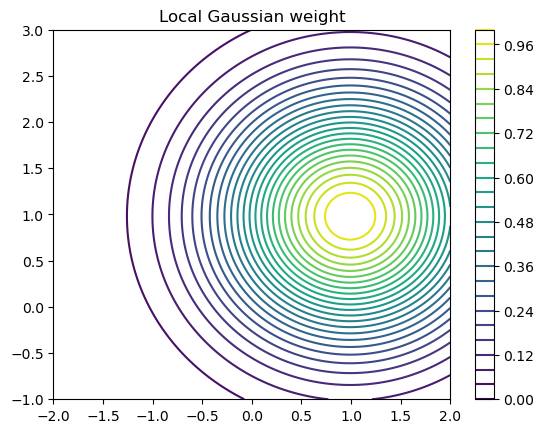

In [220]:
plt.contour(Xi, Xj, model2.covar_module.base_kernel.omega_l(Xtnew2, log_prob=False)[0].detach().numpy().reshape(Xi.shape),30)
plt.colorbar()
plt.title("Local Gaussian weight")